# Algorithmic Differentiation -- Reverse Mode

In this exercise, we want to show you how algorithmic differentiation in reverse mode works.
To do this, we show you, how this can be done with python and numpy.

Your key takehome message is, that you learn how neuronal network frameworks work.
Most frameworks hide the code that you will see in this notebook in 10 000s of lines of code.
So it is difficult to get an idea of what they do, first because of the number of code lines and second because their implementations are usually quite complicated.
The code here is mainly inspired by chainer, CNTK, and autograd.
Pytorch is also not to far away and tensorflow 2 uses a similar user API.

While the implementation of the "core" of algorithmic differentiation gives you an idea of how neuronal network frameworks work in general, the later application will give you an idea for the programming pattern of all mentioned frameworks.

What is your task:
 - Read the text and try to get an idea what the code should do (You may take later a closer look at these code blocks)
 - Answer the questions for you.
 - Search for `???` in the code. They indicate that you have to do something.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
import graphviz
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

# Fundamental building blocks

Let us define the base class of all further operations (add, subtract, ...) and a class that stores the values.
Here, it is defined that way, that the execution of the operation directly takes place
once we initialize the `Operation` object and return a `Variable` instance instead of the `Operation` instance:

```python
output_variable = Operation(input_variable_1, input_variable_2)
```

This is all written in the `__new__` method. It also takes care of storing all
input arguments (`args`, `kwargs`). The output value (`value`) is stored in the `Variable` object.

The key methods are:
- `apply`: The execution of the operation, i.e. sum two variables in the `Add` operation.
- `grad`: Calculates the gradients, when we want to do back-propagation later.

The `Variable` object stores a `value` and the `Operation` instance that produced that value in the instantiation / initialization (`__init__`).
Since the `Operation` knows its positional arguments (`args`) and keyword arguments (`kwargs`)
the complete history of the computation is known.

The remaining methodes of the `Variable` class just registers operations,
such that we can write `a + b` instead of `Add(a, b)`.

For now, you can skip the following code block. 
You can later take a deeper look at the code.

In [2]:
class Operation:
    def __new__(cls, *args, **kwargs):
        # Get a new class instance
        operation = super().__new__(cls)
        operation.__init__()
        
        # args are differentiable
        operation.args = [a if hasattr(a, 'value') else Input(a) for a in args]
        
        # Not differentiable
        for key, value in kwargs.items():
            assert not isinstance(value, Variable), (key, value)
        operation.kwargs = kwargs

        def as_numpy(a):
            if hasattr(a, 'value'):
                return a.value
            elif isinstance(a, (int, float, complex)):
                return np.asanyarray(a)
            else:
                return a

        value = np.array(operation.apply(
            *[as_numpy(a) for a in args],
            **{k: as_numpy(v) for k, v in kwargs.items()},
        ))

        assert value.dtype != object, (operation, value, value.dtype)
        return Variable(value=value, operation=operation)

    def apply(self, *args, **kwargs):
        # NOTE: This is an error message.
        #       You do not need to change something here.
        #       This message later tries to help you,
        #       when you forgot to implement the apply method.
        raise NotImplementedError(f'ToDo: implement the apply method for {type(self)}.')

    def grad(self, gz):
        # NOTE: This is an error message.
        #       You do not need to change something here.
        #       This message later tries to help you,
        #       when you forgot to implement the apply method.
        raise NotImplementedError(f'ToDo: implement the grad method for {type(self)}.')
        
    def __repr__(self):
        return f'<{self.__class__.__qualname__}>'

class Variable:
    def __init__(self, value, operation):
        self.value = np.array(value)
        self.operation = operation
    
    def backprop(self):
        # We define the backpropagation code later.
        return backprop(self)
    
    # ------------------------------------------------------ #
    # You can ignore the code below, it only defines python  #
    # magic functions to write 'a + b' instead of Add(a, b)  #
    # ------------------------------------------------------ #
        
    def __add__(self, other):                 return Add(self, other)
    def __radd__(self, other):                return Add(other, self)
    def __sub__(self, other):                 return Sub(self, other)
    def __rsub__(self, other):                return Sub(other, self)
    def __mul__(self, other):                 return Mul(self, other)
    def __rmul__(self, other):                return Mul(other, self)
    def __truediv__(self, other):             raise NotImplementedError()
    def __rtruediv__(self, other):            raise NotImplementedError()
    def __matmul__(self, other):              return MatMul(self, other)
    def __rmatmul__(self, other):             return MatMul(other, self)
    def __getitem__(self, item):              return GetItem(self, item)
    def sum(self, axis=None, keepdims=False): return Sum(self, axis=axis, keepdims=keepdims)
    def __neg__(self):                        raise NotImplementedError()
    def __pow__(self, other):                 return Pow(self, other)
    
    # With "__array_prioriy__ > 0" and an arithmetic operation with an numpy
    # ndarray (e.g. array + variable) calls "Variable.__radd__" instead of
    # ndarray.__add__.
    # https://docs.scipy.org/doc/numpy/reference/arrays.classes.html#numpy.class.__array_priority__
    __array_priority__ = 100
    
    def __repr__(self):
        def string_function(a):
            if a.size < 20:
                return str(a)
            else:
                return f'array(shape={a.shape}, dtype={a.dtype})'

        args = f'{string_function(self.value)}'
        if self.operation is not None:
            args += f', {self.operation}'
            
        return f'{self.__class__.__qualname__}({args})'

The easiest operation is the identity operation.
We provide the complete code here such that all other operations can be implemented by imitating this code.

One interesting bit is that we define the `grad()` function within the `apply()` function.
Although this may seem odd in the beginning, it allows us to access the variables which were calculated during the `apply()` function.
If you are unfamiliar with this concept, you may want to read about [Nested Functions](https://en.wikibooks.org/wiki/Python_Programming/Functions#Nested_functions) and [Closures](https://en.wikibooks.org/wiki/Python_Programming/Functions#Closures).

But be careful, the output of the `grad()` function is a tuple of as many elements as the input to the operation.

In [3]:
class Identity(Operation):
    def apply(self, x):
        z = x

        def grad(gz):
            gx = gz
            return gx,
        self.grad = grad

        return z

For learnable parameters and inputs, we could use the `Variable` class.
For convenience, let us define aliases for the `Variable` class:
The `Parameter` class and the `Input` class. We will later interprete instances of these classes as inputs or learnable parameters.

In [4]:
class Parameter(Variable):
    """
    This class should be used for Variables that are learnable.
    You can later use this class to distinguish learnable variables
    from other variables (`isinstance(variable, Parameter)`).
    """
    def __init__(self, value):
        super().__init__(value, operation=None)
        
class Input(Variable):
    """
    This class should be used as wrapper for inputs that are not learnable.
    """
    def __init__(self, value):
        super().__init__(value, operation=None)

Lets inspect, what we already have.

In [5]:
x = Identity(Input(5.))
x

Variable(5.0, <Identity>)

In [6]:
x.value

array(5.)

In [7]:
x.operation

<Identity>

In [8]:
x.operation.grad(1)

(1,)

# Numerical test code

Here, we need to handle some broadcasting details. You do not need to read this code to understand the remaining part of the exercise.

In [9]:
def handle_broadcast(input_operation, gradient, current_operation):
    # Revert broadcast for singleton dimensions
    shape = input_operation.value.shape
    axis = tuple([
        -axis
        for axis, (i, j) in enumerate(zip(shape[::-1], gradient.shape[::-1]), 1)
        if i != j or j is None
    ])
    if len(axis) > 0:
        gradient = np.sum(gradient, axis=axis, keepdims=True)

    # Revert broadcast for independent dims
    axis = tuple([*range(len(gradient.shape) - len(shape))])
    if len(axis) > 0:
        gradient = np.sum(gradient, axis=axis, keepdims=False)

    message = (input_operation, current_operation, gradient, gradient.shape, shape)
    assert gradient.shape == shape, message
    return gradient

Try to go through the numeric test code.

 - Why do we define gradient functions ourselfs in algorithmic differentiation, if we could just use the numeric gradients?

Answer: Here's why we prefer analytical gradients (algorithmic differentiation) over numerical gradients:

1. **Precision**:
   - **Analytical**: Exact to machine precision
   - **Numerical**: Approximate, prone to truncation and rounding errors

2. **Speed**:
   - **Analytical**: Computes all gradients in one backward pass
   - **Numerical**: Requires O(n) forward passes for n parameters

3. **Memory Efficiency**:
   - **Analytical**: Can be memory efficient with reverse-mode AD
   - **Numerical**: Needs to store all intermediate states

4. **Stability**:
   - **Analytical**: More stable for extreme parameter values
   - **Numerical**: Can be unstable due to floating-point errors

5. **Implementation**:
   - **Analytical**: More complex to implement initially
   - **Numerical**: Easier to implement but less efficient

Example in deep learning:
- A neural network with 1M parameters
- **Numerical**: Requires 1M+1 forward passes per gradient step
- **Analytical**: Requires just 1 forward and 1 backward pass

That's why frameworks like PyTorch and TensorFlow use automatic differentiation rather than numerical methods.

In [10]:
def numeric_test(variable, *, eps=1e-7, rtol=1e-7, atol=0):
    assert isinstance(variable, Variable), f'Can only calculate gradients for Graph elements and not for {variable}.'
    for arg in variable.operation.args:
        if not isinstance(arg, (Input, Parameter)):
            if isinstance(arg, Variable):
                raise AssertionError(
                    'Each arg of the operation has to be an Input or Parameter.\n'
                    'Intermediate variables are not allowed.\n'
                    f'The operation {variable.operation} got the input argument: {arg}.\n'
                    'Change the Variable to an Input or Parameter.'
                )
            else:
                raise AssertionError(
                    f'Can only calculate gradients for Graph elements and not for {arg}.'
                )        

    args = [
        np.array(arg.value, dtype=np.float64) 
        for arg in variable.operation.args
    ]

    gout = np.random.normal(size=variable.value.shape)
    
    gin = variable.operation.grad(gout)
    if not isinstance(gin, tuple):
        raise AssertionError(
            f'The grad function of {type(variable.operation)} returned a {type(gin)}.\n'
            f'The grad function should always return a tuple: e.g.: "return gx," or "return gx, gy".\n'
            f'Did you forgot to write the comma?'
        )
    
    gin = list(gin)
    for i in range(len(gin)):
        gin[i] = handle_broadcast(variable.operation.args[i], gin[i], variable.operation)

    gin_numeric = [np.zeros_like(g) for g in gin]
    for i in range(len(gin)):
        # Iterate through every element in every input
        for nd_idx in np.ndindex(args[i].shape):
            args[i][nd_idx] += eps
            out_eps = variable.operation.apply(*args, **variable.operation.kwargs)
            gin_numeric[i][nd_idx] = np.sum(gout * (out_eps - variable.value)) / eps
            args[i][nd_idx] -= eps

    for i in range(len(gin)):
        np.testing.assert_allclose(gin[i], gin_numeric[i], rtol=rtol, atol=atol)

In [11]:
x = Parameter(123.)
y = Identity(x)
numeric_test(y)

# Define and test each operation

Now we start to define a bunch of operations we might need to reconstruct the theory exercise about algorithmic differentiation.

You need to define each `apply()` function and each `grad()` function. You can then run the provided test case to check if your gradient calculation matches the numerical gradient.

In [12]:
class Add(Operation):
    def apply(self, x, y):
        z = x + y 

        def grad(gz):
            return gz, gz  
        self.grad = grad

        return z

x = Parameter(123.)
y = Parameter(-100.)
z = x + y
np.testing.assert_allclose(z.value, 23.)
numeric_test(z)

In [13]:
class Sub(Operation):
    def apply(self, x, y):
        z = x - y  

        def grad(gz):
            return gz, -gz  
        self.grad = grad

        return z

x = Parameter(123.)
y = Parameter(-100.)
z = x - y
np.testing.assert_allclose(z.value, 223.)
numeric_test(z)

In [14]:
class Mul(Operation):
    def apply(self, x, y):
        z = x * y  

        def grad(gz):
            return gz * y, gz * x  
        self.grad = grad

        return z

x = Parameter(123.)
y = Parameter(-100.)
z = x * y
np.testing.assert_allclose(z.value, -12300.)
numeric_test(z)

The rectified linear unit is already a tricky beast.
It is not differentiable at 0, nevertheless, it is frequently used in todays neural networks.
The gradient is implemented in such a way that the tangent of the curve is always below the curve itself (sometimes called subgradient).
In practice, this means that we can assume that the gradient is $1$ at $x = 0$ without losing anything.

Check the difference between `np.max()` and `np.maximum()` to solve this part of the exercise.

Answer: Here's the difference between `np.max()` and `np.maximum()` in NumPy:

### `np.max()`
- **Purpose**: Finds the maximum value in an array or along an axis
- **Signature**: `np.max(array, axis=None)`
- **Returns**: A single maximum value or an array of max values along the specified axis
- **Example**:
  ```python
  import numpy as np
  arr = np.array([1, 2, 3])
  print(np.max(arr))  # Output: 3
  print(np.max([[1, 2], [3, 4]], axis=0))  # Output: [3, 4]
  ```

### `np.maximum()`
- **Purpose**: Element-wise maximum of two arrays
- **Signature**: `np.maximum(array1, array2)`
- **Returns**: A new array containing element-wise maximums
- **Example**:
  ```python
  arr1 = np.array([1, 3, 5])
  arr2 = np.array([2, 2, 4])
  print(np.maximum(arr1, arr2))  # Output: [2, 3, 5]
  ```

### Key Differences:
1. **Input**:
   - `max()`: Takes a single array (and optional axis)
   - `maximum()`: Takes exactly two arrays (or array and scalar)

2. **Operation**:
   - `max()`: Reduction operation (returns a smaller array or scalar)
   - `maximum()`: Element-wise operation (returns array of same shape)

3. **Use Case**:
   - Use `max()` to find the largest value
   - Use `maximum()` to clip values or compare two arrays element-wise

In [15]:
class ReLU(Operation):
    def apply(self, x):
        z = np.maximum(x, 0)  

        def grad(gz):
            gx = gz.copy()
            
            # Modify `gx` such that the gradient is corrected for x < 0.
            gx[x < 0] = 0  
            return gx,
        self.grad = grad

        return z

x = Parameter(123.)
z = ReLU(x)
np.testing.assert_allclose(z.value, 123.)
numeric_test(z)

x = Parameter(-123.)
z = ReLU(x)
np.testing.assert_allclose(z.value, 0.)
numeric_test(z)


x = Parameter([-123., 123.])
z = ReLU(x)
np.testing.assert_allclose(z.value, [0., 123.])
numeric_test(z)

# Reproduce theory exercise

Reproduce the execution graph of the theory exercise by first defining the inputs as variables using `Parameter` and then adding further graph elements.

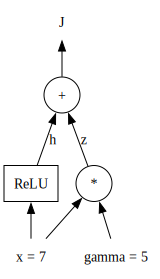

In [16]:
dot = graphviz.Digraph()
dot.attr(rankdir='BT')  # draw from bottom to top
dot.node('x', 'x = 7', shape='plaintext')
dot.node('gamma', 'gamma = 5', shape='plaintext')
dot.node('J', 'J', shape='plaintext')

dot.node('relu', 'ReLU', shape='box')
dot.node('plus', '+', shape='circle')
dot.node('mul', '*', shape='circle')

dot.edge('x', 'relu')
dot.edge('x', 'mul')
dot.edge('gamma', 'mul')
dot.edge('relu', 'plus', 'h')
dot.edge('mul', 'plus', 'z')
dot.edge('plus', 'J')

dot

In [17]:
x = Parameter(7) 
gamma = Parameter(5) 

h = ReLU(x)
z = x * gamma  
J = h + z

np.testing.assert_allclose(J.value, 42.)

Let us now get the execution order. Does the execution order match the execution order of the theory exercise?
Is this a [Depth-first search](https://en.wikipedia.org/wiki/Depth-first_search) or is it a [Breadth-first search](https://en.wikipedia.org/wiki/Breadth-first_search)?

Please go through the code and understand, which elements are added to the `all_variables` list first.

Answer:
Let's analyze the execution order in the code to understand how it processes the computational graph.

### Execution Order Analysis:

1. **Initialization**:
   - `all_variables` list is empty initially
   - The graph is built from bottom to top (inputs to outputs)

2. **Processing Order**:
   - Variables are added to `all_variables` in the order they are created
   - When an operation is performed, its result is a new Variable added to the list
   - The graph is processed in **reverse order** (from output back to inputs) during backpropagation

3. **Search Type**:
   - The execution follows a **Depth-First Search (DFS)** pattern because:
     - It processes each branch completely before moving to the next branch
     - It goes as deep as possible along each branch before backtracking

4. **Example**:
   For an expression like `y = x * w + b`:
   ```
   x * w → mul_node
   mul_node + b → add_node
   ```
   The order in `all_variables` would be: [x, w, mul_node, b, add_node]

5. **Backpropagation**:
   - Starts from the output and moves backward
   - Uses the chain rule to compute gradients
   - Each node's gradient depends on the gradients of the nodes that follow it

The execution order matches the theoretical reverse-mode automatic differentiation, where we first do a forward pass to compute values and then a backward pass to compute gradients.

In [18]:
def get_variables(variable):
    if not isinstance(variable, Variable):
        raise TypeError(
            f'Expect something of type {Variable} and not of type {type(variable)}. Variable: {variable}'
        )
    all_variables = []

    def recursive_call(variable):
        if isinstance(variable, Variable):
            if variable.operation is not None:
                for input_variable in variable.operation.args:
                    if input_variable not in all_variables:
                        recursive_call(input_variable)
            all_variables.append(variable)

    recursive_call(variable)
    return all_variables

get_variables(J)

[Parameter(7),
 Variable(7, <ReLU>),
 Parameter(5),
 Variable(35, <Mul>),
 Variable(42, <Add>)]

Now, that we are able to obtain the execution order (i.e. the operation that produced the variable value), it may be more fun to visualize the calculations within the graph.

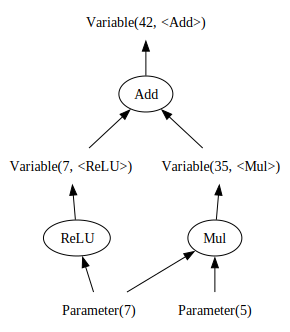

In [19]:
def visualize(variable):
    all_variable = get_variables(variable)

    dg = graphviz.Digraph()
    dg.attr(rankdir='BT')  # draw from bottom to top
    dg.attr(size='6')
    for variable in all_variable:
         #dg.node(str(id(variable)), str(variable), shape='box')
        dg.node(str(id(variable)), str(variable), shape='plaintext')
        
        if variable.operation is not None:
            dg.node(str(id(variable.operation)), str(variable.operation))
            dg.edge(str(id(variable.operation)), str(id(variable)))
            for input_variable in variable.operation.args:
                edge_label = None
                dg.edge(str(id(input_variable)), str(id(variable.operation)), label=edge_label)
    return dg

visualize(J)

Since we know the computation graph, we can now calculate the gradients.
Algorithmic differentiation in reverse mode is also known as backpropagation.

Try to understand how the backpropagation code works.

 - Why is `map_variable_to_gradient` initialized with zeros?
 - And why is the returned gradient from `operation.grad(...)` added to the old value?
 - In which order do we call `operation.grad(...)`?
 - Do you know the Multivariable chain rule?

Answer: The backpropagation implementation:

### 1. `map_variable_to_gradient` Initialization
```python
map_variable_to_gradient = {v: np.zeros_like(v.value) for v in all_variables}
```
- **Why zeros?** Each variable's gradient is initialized to zero because gradients are accumulated (summed) from all paths in the computational graph. Starting from zero ensures we don't have any initial bias in the gradient calculation.

### 2. Gradient Accumulation
```python
grads = operation.grad(gz)  # Get gradients from operation
for arg, grad in zip(operation.args, grads):
    if grad is not None:
        map_variable_to_gradient[arg] = map_variable_to_gradient[arg] + grad
```
- **Why add to old value?** The chain rule requires summing gradients from all paths. If a variable is used in multiple operations (like `x` in `x * x`), gradients from all uses must be summed.

### 3. Execution Order
- **Order of `operation.grad()` calls**: We process operations in **reverse topological order** (output to inputs). This ensures that when we compute a gradient, all gradients of operations that depend on it have already been computed.

### 4. Multivariable Chain Rule
The chain rule for `z = f(g(x,y))` is:
```
∂z/∂x = (∂z/∂f) * (∂f/∂x)
∂z/∂y = (∂z/∂f) * (∂f/∂y)
```

### Example Walkthrough:
For `z = x * y + x`:
1. Forward pass:
   - `a = x * y` (mul_op)
   - `z = a + x` (add_op)

2. Backward pass:
   - Initialize gradients: `dz/dz = 1`
   - `add_op.grad(1)` → returns `[1, 1]` (gradient flows to both inputs)
   - `dz/da = 1`, `dz/dx = 1`
   - `mul_op.grad(1)` → returns `[y, x]` (gradients for x and y)
   - Final gradients:
     - `dz/dx = 1 (from add) + y (from mul)`
     - `dz/dy = x (from mul)`

This implementation efficiently computes gradients by reusing intermediate results and following the chain rule through the computational graph.

In [20]:
def backprop(loss): # is "loss" the value of MSE calculated at feed-forward ?
    assert loss.value.shape == (), f'The loss should be a scalar. shape {loss.value.shape}'
    
    map_variable_to_gradient = OrderedDict() 
    for variable in reversed(get_variables(loss)):
        map_variable_to_gradient[variable] = np.array(0.)

    map_variable_to_gradient[loss] = np.array(1.)
    
    for variable in map_variable_to_gradient.keys():
        operation = variable.operation
        if operation is not None:
            gradients = operation.grad(map_variable_to_gradient[variable])

            message = (operation, type(gradients), gradients)
            assert isinstance(gradients, tuple), message
            message = (len(gradients), len(operation.args))
            assert len(gradients) == len(operation.args), message

            for input_argument, gradient in zip(operation.args, gradients):
                input_variable = input_argument
                map_variable_to_gradient[input_variable] = np.array(
                        map_variable_to_gradient[input_variable]
                        + handle_broadcast(
                            input_operation=input_variable,
                            gradient=np.array(gradient),
                            current_operation=operation,
                        )
                )

    return map_variable_to_gradient
backprop(J)

OrderedDict([(Variable(42, <Add>), array(1.)),
             (Variable(35, <Mul>), array(1.)),
             (Parameter(5), array(7.)),
             (Variable(7, <ReLU>), array(1.)),
             (Parameter(7), array(6.))])

# Reproduce theory exercise 2

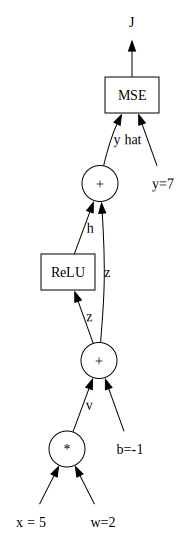

In [21]:
dot = graphviz.Digraph()
dot.attr(rankdir='BT')  # draw from bottom to top
dot.node('x', 'x = 5', shape='plaintext')
dot.node('w', 'w=2', shape='plaintext')
dot.node('b', 'b=-1', shape='plaintext')
dot.node('y', 'y=7', shape='plaintext')
dot.node('J', 'J', shape='plaintext')

dot.node('mul', '*', shape='circle')
dot.node('plus1', '+', shape='circle')
dot.node('relu', 'ReLU', shape='box')
dot.node('plus2', '+', shape='circle')
dot.node('mse', 'MSE', shape='box')

dot.edge('x', 'mul')
dot.edge('w', 'mul')
dot.edge('mul', 'plus1', 'v')
dot.edge('b', 'plus1')
dot.edge('plus1', 'relu', 'z')
dot.edge('relu', 'plus2', 'h')
dot.edge('plus1', 'plus2', 'z')
dot.edge('plus2', 'mse', 'y hat')
dot.edge('y', 'mse')
dot.edge('mse', 'J')

dot

The excercises contain two examples for algorithmic differentation. The second example (Excercise 4.1, Homework) contains a mean square error (MSE).

Reproduce the execution graph of that theory exercise by first defining the MSE operation.
Instantiate the inputs as parameters using `Parameter` and then adding further graph elements.

 - How is the operation mean square error (MSE) defined?
 - What is the derivative of MSE with respect to the inputs y and y hat?

In [22]:
class MSE(Operation):
    def apply(self, x, y):
        difference = x - y  # REPLACE
        z = np.mean(difference ** 2)  # REPLACE z = ???

        def grad(gz):
            gz = np.broadcast_to(gz, x.shape)
            gx = 2 * difference * gz / x.size # REPLACE gx = ???
            gy = -gx  # REPLACE gy = ???
            return gx, gy
        self.grad = grad

        return z

x = Parameter(1.)
y = Parameter(-1.)
z = MSE(x, y)
np.testing.assert_allclose(z.value, 4.)
numeric_test(z, eps=1e-10)

x = Parameter(np.ones(4))
y = Parameter([1, 1, 1, 0.])
z = MSE(x, y)
np.testing.assert_allclose(z.value, 0.25)
numeric_test(z, eps=1e-10)

In [23]:
x = Parameter(5)  
w = Parameter(2) 
b = Parameter(-3) 
y = Parameter(7) 

v = w * x  
z = v + b  
h = ReLU(z) 
y_hat = h + z 
J = MSE(y_hat, y)  

np.testing.assert_allclose(J.value, 49.)

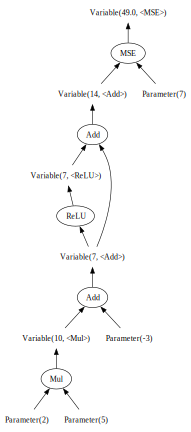

In [24]:
visualize(J)

In [25]:
backprop(J)

OrderedDict([(Variable(49.0, <MSE>), array(1.)),
             (Parameter(7), array(-14.)),
             (Variable(14, <Add>), array(14.)),
             (Variable(7, <ReLU>), array(14.)),
             (Variable(7, <Add>), array(28.)),
             (Parameter(-3), array(28.)),
             (Variable(10, <Mul>), array(28.)),
             (Parameter(5), array(56.)),
             (Parameter(2), array(140.))])

# Define more operations and symbolic functions

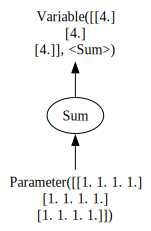

In [38]:
class Sum(Operation):
    def apply(self, x, axis=None, keepdims=False):
    # Ensure axis is a Python int or tuple of ints
        if isinstance(axis, np.ndarray):
            axis = axis.tolist()
        if isinstance(axis, list):
            axis = tuple(axis) if len(axis) > 1 else (axis[0] if axis else None)
        
        self.axis = axis
        self.keepdims = bool(keepdims)  # Ensure boolean
        self.x_shape = x.shape
    
        z =  np.sum(x, axis=self.axis, keepdims=self.keepdims)

        def grad(gz):
            if axis is None:
                return np.broadcast_to(gz, x.shape),
            
            if keepdims:
                gx = np.reshape(gz, z.shape)
                return np.broadcast_to(gx, x.shape),
            else:
                shape = list(x.shape)
                shape[axis] = 1
                gx = np.reshape(gz, shape)
                return np.broadcast_to(gx, x.shape),
        
        self.grad = grad

        return z

x = Parameter(1.)
z = Sum(x)
np.testing.assert_allclose(z.value, 1.)
numeric_test(z)

x = Parameter(np.ones((3, 4)))
z = Sum(x)
np.testing.assert_allclose(z.value, 12.)
numeric_test(z)

x = Parameter(np.ones((3, 4)))
z = Sum(x, axis=1)
np.testing.assert_allclose(z.value, 4 * np.ones(3))
numeric_test(z, eps=1-7)

x = Parameter(np.ones((3, 4)))
z = Sum(x, axis=1, keepdims=True)
np.testing.assert_allclose(z.value, 4 * np.ones((3, 1)))
numeric_test(z)

visualize(z)

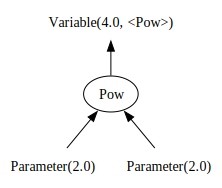

In [39]:
class Pow(Operation):
    def apply(self, x, y):
        z = x ** y

        def grad(gz):
            gx = gz * y * (x ** (y - 1))
            gy = gz * np.log(x) * z
            return gx, gy
        self.grad = grad

        return z

x = Parameter(2.)
y = Parameter(2.)
z = x ** y
np.testing.assert_allclose(z.value, 4.)
numeric_test(z, eps=1e-10, rtol=1e-6, atol=1e-7)
visualize(z)

Now, that we defined a lot of elemantary operations, we can also compose them to larger building blocks. That way, we do not need to define the gradients anymore. Define the MSE function using only the predefined operations.

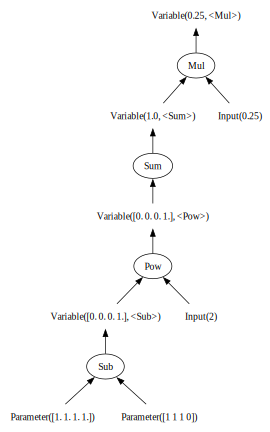

In [40]:
def symbolic_MSE(x, y):
    difference = x - y  
    return Sum(difference ** 2) * Input((1 / difference.value.size)) 

x = Parameter(1.)
y = Parameter(-1.)
z = symbolic_MSE(x, y)
np.testing.assert_allclose(z.value, 4.)

x = Parameter(np.ones(4))
y = Parameter([1, 1, 1, 0])
z = symbolic_MSE(x, y)
np.testing.assert_allclose(z.value, 0.25)
visualize(z)

Visualize the complete graph from the second theoretical exercise again using the `symbolic_MSE` function. What changed?

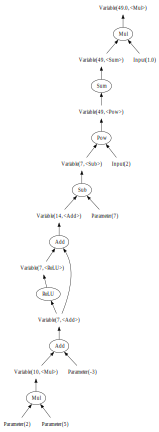

In [41]:
x = Parameter(5)  
w = Parameter(2)  
b = Parameter(-3)  
y = Parameter(7)  

v = w * x  
z = v + b  
h = ReLU(z)  
y_hat = h + z  
J = symbolic_MSE(y_hat, y)  

np.testing.assert_allclose(J.value, 49.)
visualize(J)

## This is the end of the exercise.
---

# Preparation for the homework assignment

To prepare for the homework assignment, we need to define more operations. The matrix multiplication gradient is already everything but trivial. If you are interested, you can check the implementation of the gradient.

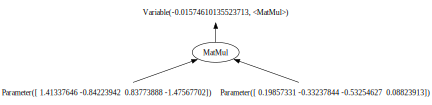

In [42]:
class MatMul(Operation):
    def apply(self, x, y):

        z = x @ y  # REPLACE z = ???

        def grad(gz):
            if x.ndim > 1 and y.ndim > 1:
                return gz @ np.swapaxes(y, -2, -1), np.swapaxes(x, -2, -1) @ gz
            elif x.ndim == 1 and y.ndim > 1:
                return gz @ np.swapaxes(y, -2, -1), np.einsum('i,...j->...ij', x, gz)
            elif x.ndim > 1 and y.ndim == 1:
                return np.einsum('...i,j->...ij', gz, y), np.swapaxes(x, -2, -1) @ gz
            elif x.ndim == 1 and y.ndim == 1:
                return np.einsum(',j->j', gz, y), np.einsum('i,->i', x, gz)
            else:
                raise NotADirectoryError(x.ndim, y.ndim)
        self.grad = grad

        return z

x = Parameter(np.random.normal(size=[2, 4]))
y = Parameter(np.random.normal(size=[4, 3]))
z = x @ y
numeric_test(z, eps=1e-1)

x = Parameter(np.random.normal(size=[4]))
y = Parameter(np.random.normal(size=[4, 3]))
z = x @ y
numeric_test(z, eps=1e-1)

x = Parameter(np.random.normal(size=[2, 4]))
y = Parameter(np.random.normal(size=[4]))
z = x @ y
numeric_test(z, eps=1e-1)

x = Parameter(np.random.normal(size=[4]))
y = Parameter(np.random.normal(size=[4]))
z = x @ y
numeric_test(z, eps=1e-1)
visualize(z)

Now, that we know how to combine graph elements, we can also define layers or complete models. Here are two different ways, how to define an affine layer (sometimes called feed-forward layer).

In [43]:
def AffineLayer(in_units, out_units):
    small_value = 0.01
    W = Parameter(
        np.random.uniform(
            size=[in_units, out_units],
            low=-small_value,
            high=small_value
        )
    )
    b = Parameter(np.zeros(shape=out_units))

    def affine_layer(x):
        return (x @ W) + b

    # Not nessesary
    affine_layer.W = W
    affine_layer.b = b
    
    return affine_layer

affine_layer = AffineLayer(3,3)
x = Parameter(np.random.normal(size=3))
z = affine_layer(x)
z.value.shape

(3,)

In [44]:
#small_value = 1
#W = Parameter(
#    np.random.uniform(
#        size=[2, 2],
#        low=-small_value,
#        high=small_value
#    )
#)
#W


In [45]:
class AffineLayer:
    def __init__(self, in_units, out_units):
        small_value = 0.01
        self.W = Parameter(
            np.random.uniform(
                size=[in_units, out_units],
                low=-small_value,
                high=small_value
            )
        )
        #self.b = Parameter(np.zeros(shape=out_units))
        
    def __call__(self, x):
        return (x @ self.W) #+ self.b

affine_layer = AffineLayer(3, 3)
x = Parameter(np.random.normal(size=3))
z = affine_layer(x)
z.value.shape

(3,)

When different layers are combined, often a `Sequential` class is used.
Here is an example implementation of such a class:

In [46]:
class Sequential:
    def __init__(self, *layers):
        self.layers = layers
        
    def __call__(self, input):
        hidden_state = input
        for layer in self.layers:
            hidden_state = layer(hidden_state)
        return hidden_state
    
Sequential(AffineLayer(3, 3), AffineLayer(3, 10),  AffineLayer(10, 3))(x)

Variable([8.30430461e-07 1.43693556e-06 1.16150835e-06], <MatMul>)

Assuming, your Jupyter notebook has internet connection, we can already download the MNIST dataset and look at the data structure. If you work on [cocalc.com](https://cocalc.com/), you will not have an internet connection.

In [47]:
def get_mnist():
    # The code to download the mnist data original came from
    # https://cntk.ai/pythondocs/CNTK_103A_MNIST_DataLoader.html
    
    import gzip
    import numpy as np
    import os
    import struct

    from urllib.request import urlretrieve 

    def load_data(src, num_samples):
        print("Downloading " + src)
        gzfname, h = urlretrieve(src, "./delete.me")
        print("Done.")
        try:
            with gzip.open(gzfname) as gz:
                n = struct.unpack("I", gz.read(4))
                # Read magic number.
                if n[0] != 0x3080000:
                    raise Exception("Invalid file: unexpected magic number.")
                # Read number of entries.
                n = struct.unpack(">I", gz.read(4))[0]
                if n != num_samples:
                    raise Exception(
                        "Invalid file: expected {0} entries.".format(num_samples)
                    )
                crow = struct.unpack(">I", gz.read(4))[0]
                ccol = struct.unpack(">I", gz.read(4))[0]
                if crow != 28 or ccol != 28:
                    raise Exception(
                        "Invalid file: expected 28 rows/cols per image."
                    )
                # Read data.
                res = np.frombuffer(
                    gz.read(num_samples * crow * ccol), dtype=np.uint8
                )
        finally:
            os.remove(gzfname)
        return res.reshape((num_samples, crow, ccol)) / 256


    def load_labels(src, num_samples):
        print("Downloading " + src)
        gzfname, h = urlretrieve(src, "./delete.me")
        print("Done.")
        try:
            with gzip.open(gzfname) as gz:
                n = struct.unpack("I", gz.read(4))
                # Read magic number.
                if n[0] != 0x1080000:
                    raise Exception("Invalid file: unexpected magic number.")
                # Read number of entries.
                n = struct.unpack(">I", gz.read(4))
                if n[0] != num_samples:
                    raise Exception(
                        "Invalid file: expected {0} rows.".format(num_samples)
                    )
                # Read labels.
                res = np.frombuffer(gz.read(num_samples), dtype=np.uint8)
        finally:
            os.remove(gzfname)
        return res.reshape((num_samples))


    def try_download(data_source, label_source, num_samples):
        data = load_data(data_source, num_samples)
        labels = load_labels(label_source, num_samples)
        return data, labels
    
    # Not sure why, but yann lecun's website does no longer support 
    # simple downloader. (e.g. urlretrieve and wget fail, while curl work)
    # Since not everyone has linux, use a mirror from uni server.
    #     server = 'http://yann.lecun.com/exdb/mnist'
    server = 'https://raw.githubusercontent.com/fgnt/mnist/master'
    
    # URLs for the train image and label data
    url_train_image = f'{server}/train-images-idx3-ubyte.gz'
    url_train_labels = f'{server}/train-labels-idx1-ubyte.gz'
    num_train_samples = 60000

    print("Downloading train data")
    train_features, train_labels = try_download(url_train_image, url_train_labels, num_train_samples)

    # URLs for the test image and label data
    url_test_image = f'{server}/t10k-images-idx3-ubyte.gz'
    url_test_labels = f'{server}/t10k-labels-idx1-ubyte.gz'
    num_test_samples = 10000

    print("Downloading test data")
    test_features, test_labels = try_download(url_test_image, url_test_labels, num_test_samples)
    
    return train_features, train_labels, test_features, test_labels

In [48]:
train_features, train_labels, test_features, test_labels = get_mnist()

Done.
Done.
Done.
Done.


In [49]:
np.sort(test_labels).shape

(10000,)

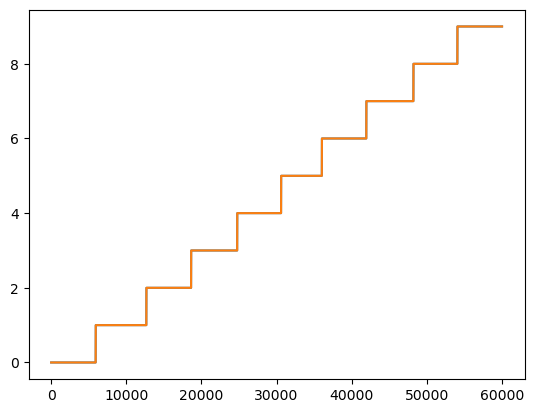

In [52]:
plt.plot(np.sort(train_labels))
plt.show()

In [54]:
#feature_train, feature_test = np.split(mnist['data'], [60000])
#label_train, label_test = np.split(mnist['target'], [60000])

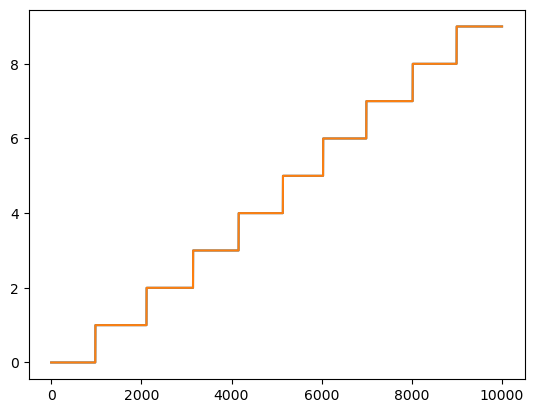

In [56]:
plt.plot(np.sort(test_labels))
plt.show()

In [57]:
train_features.shape

(60000, 28, 28)

In [58]:
test_features.shape

(10000, 28, 28)

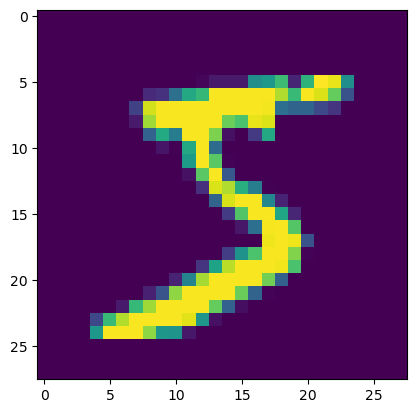

In [60]:
plt.imshow(train_features[0])
plt.show()

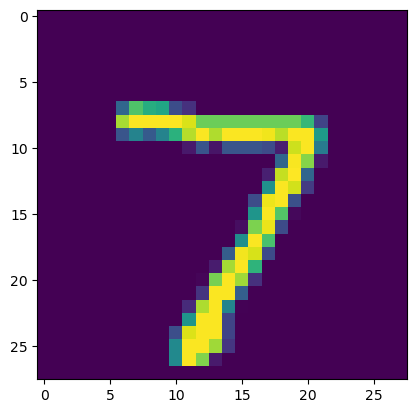

In [61]:
plt.imshow(test_features[0])
plt.show()

# Further tips

In [62]:
# Access a gradient from the dictionary:

mu = -0.01

print('Manual')
x = Input(np.array([1.]))
J = (x * x).sum()
gradient_dict = backprop(J)
g = gradient_dict[x]
print(x.value)
x.value += mu * g
print(x.value)

# or:

print('Manual with layers')
x = Input(np.array([1.]))
dense_layer = AffineLayer(1, 1)
J = dense_layer(x).sum()
gradient_dict = backprop(J)
g = gradient_dict[dense_layer.W]
print(dense_layer.W.value)
dense_layer.W.value += mu * g
print(dense_layer.W.value)

# or:

print('Automatic')
for k, g in gradient_dict.items():
    if isinstance(k, Parameter):
        print(k.value)
        k.value += mu * g
        print(k.value)

Manual
[1.]
[0.98]
Manual with layers
[[0.00361126]]
[[-0.00638874]]
Automatic
[[-0.00638874]]
[[-0.01638874]]


In [63]:
import json

In [64]:
# Save the parameters

def dump_parameters(loss, file):
    variables = get_variables(J)
    parameters = [
        v 
        for v in variables
        if isinstance(v, Parameter)
    ]
    with open(file, 'w') as fp:
        json.dump([p.value.tolist() for p in parameters], fp)
    print('Wrote the parameters')
    print(parameters)
    print('to', file)

dump_parameters(loss=J, file='parameters.json')

Wrote the parameters
[Parameter([[-0.01638874]])]
to parameters.json


In [65]:
# Restore the parameters

def load_parameters(loss, file):
    variables = get_variables(J)
    parameters = [
        v 
        for v in variables
        if isinstance(v, Parameter)
    ]
    with open(file) as fp:
        parameters_values = json.load(fp)
    for p, p_value in zip(parameters, parameters_values):
        print(p.value, p_value)
        p.value[...] = p_value
        
    print('Loaded the parameters')
    print(parameters)
    print('from', file)
        
load_parameters(loss=J, file='parameters.json')

[[-0.01638874]] [[-0.016388735667739476]]
Loaded the parameters
[Parameter([[-0.01638874]])]
from parameters.json
